In [1]:
import random

from   keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from   PIL import Image, ImageDraw, ImageFont
import tensorflow as tf
from   tensorflow.keras.datasets import fashion_mnist
from   tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Input, Lambda)
from   tensorflow.keras.models import Model
from   tensorflow.keras.optimizers import RMSprop
from   tensorflow.python.keras.utils.vis_utils import plot_model

In [2]:
def create_pairs(x, digit_inds, n_classes=10):
    '''
    Positive and negative pair creation.  Alternates between +/- pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_inds[d]) for d in range(n_classes)]) - 1
    for d in range(n_classes):
        for i in range(n):
            z1, z2 = digit_inds[d][i], digit_inds[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, n_classes)
            dn = (d + inc) % n_classes
            z2 = digit_inds[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [3]:
def create_pairs_on_set(images, labels, n_classes=10):
    digit_inds = [np.where(labels == i)[0] for i in range(n_classes)]
    pairs, y = create_pairs(images, digit_inds)
    y = y.astype('float32')
    return pairs, y

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist\
    .load_data()

In [5]:
def prep_data(images, labels):
    images = images.astype('float32')
    images = images / 255.
    pairs, y = create_pairs_on_set(images, labels)
    return images, pairs, y

In [6]:
train_images, tr_pairs, tr_y = prep_data(train_images, train_labels)
test_images, ts_pairs, ts_y = prep_data(test_images, test_labels)

In [7]:
def show_image(img):
    plt.figure()
    plt.imshow(img)
    plt.colorbar()
    plt.grid(False)
    plt.show()

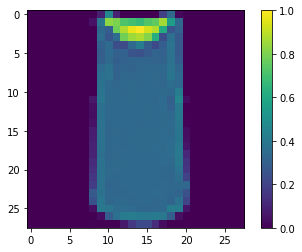

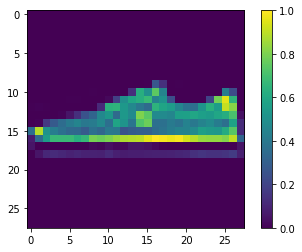

0.0


In [8]:
this_pair = 3
show_image(tr_pairs[this_pair][0])
show_image(tr_pairs[this_pair][1])
print(tr_y[this_pair])

In [17]:
def init_base_network(
        inshape=(28, 28,), n_dense=3, dense_nodes=128, dropout=0.1):
    input = Input(shape=inshape, name='base_input')
    x = Flatten(name='flat')(input)
    for i in range(n_dense):
        x = Dense(dense_nodes, activation='relu', name=f'd{i + 1}')(x)
        x = Dropout(dropout, name=f'dropout{i + 1}')(x)
    return Model(inputs=input, outputs=x)

In [21]:
def get_euclidean_distance(vs):
    x, y = vs
    ss = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(ss, K.epsilon()))

In [22]:
def get_eucl_dist_output_shape(shapes):
    s1, s2 = shapes
    return (s1[0], 1)

In [23]:
base_network = init_base_network()

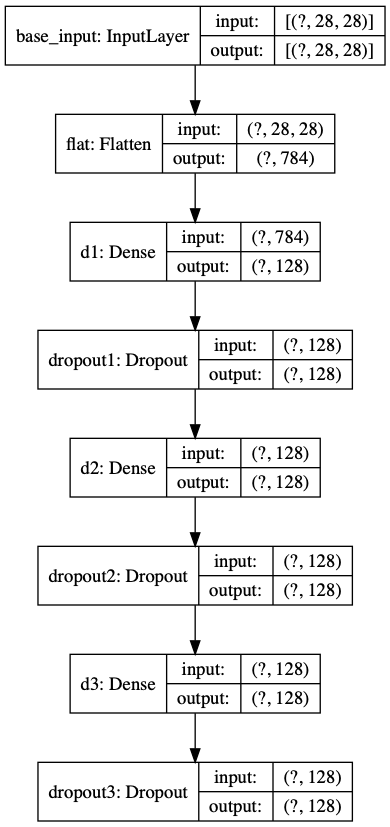

In [24]:
plot_model(base_network, show_shapes=True, show_layer_names=True)

In [25]:
input_a = Input(shape=(28, 28), name='left_in')
vec_output_a = base_network(input_a)
input_b = Input(shape=(28, 28), name='right_in')
vec_output_b = base_network(input_b)

In [26]:
output = Lambda(
    get_euclidean_distance, 
    name='output', 
    output_shape=get_eucl_dist_output_shape
)([vec_output_a, vec_output_b])

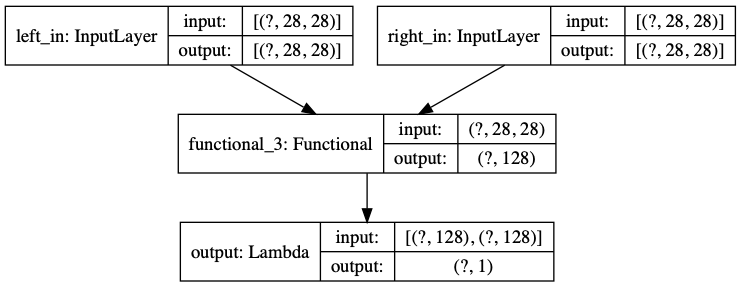

In [28]:
mod = Model([input_a, input_b], output)
plot_model(mod, show_shapes=True, show_layer_names=True)

In [29]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y, pred):
        '''
        From Hadsell et al. (2006), see:
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        sq_pred = K.square(pred)
        marg_sq = K.square(K.maximum(margin - pred, 0))
        return K.mean(y*sq_pred + (1 - y)*marg_sq)
    return contrastive_loss

In [30]:
rms = RMSprop()
mod.compile(loss=contrastive_loss_with_margin(1), optimizer=rms)

In [32]:
EPOCHS = 20
BATCH = 128

In [37]:
history = mod.fit(
    [tr_pairs[:, 0], tr_pairs[:, 1]], 
    tr_y, 
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_data=([ts_pairs[:, 0], ts_pairs[:, 1]], ts_y))

Epoch 1/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0924 - val_loss: 0.0719
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0921 - val_loss: 0.0705
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0917 - val_loss: 0.0709
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0914 - val_loss: 0.0740
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0915 - val_loss: 0.0736
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0913 - val_loss: 0.0729
Epoch 7/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0911 - val_loss: 0.0694
Epoch 8/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0912 - val_loss: 0.0726
Epoch 9/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0908 - val_loss: 0.0726
Epoch 10/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0905 - val_loss: 0.0719

In [38]:
loss = mod.evaluate(x=[ts_pairs[:, 0], ts_pairs[:, 1]], y=ts_y)
loss

625/625 [==============================] - 1s 809us/step - loss: 0.0710


0.07096252590417862

In [39]:
def compute_accuracy(y, pred):
    pred = pred.ravel() > 0.5
    return np.mean(pred == y)

In [40]:
y_pred_train = mod.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
train_acc = compute_accuracy(tr_y, y_pred_train)
y_pred_test = mod.predict([ts_pairs[:, 0], ts_pairs[:, 1]])
test_acc = compute_accuracy(ts_y, y_pred_test)

In [42]:
print(f'Train Acc: {train_acc}\nTest Acc:  {test_acc}')

Train Acc: 0.05923487247874646
Test Acc:  0.08673673673673674


In [45]:
def plot_metrics(history, name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[name], color='blue', label=name)
    vname = f'val_{name}'
    plt.plot(history.history[vname], color='red', label=vname)

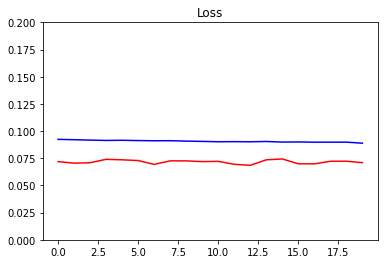

In [47]:
plot_metrics(history, 'loss',  'Loss', 0.2)

In [48]:
def vis_imgs():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc(
        'axes', facecolor='f8f8f8', titlesize='large', edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='f0f0f0')

In [52]:
def display_imgs(left, right, preds, labels, title, n):
    plt.figure(figsize=[17, 3])
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    
    plt.figure(figsize=[17, 3])
    plt.yticks([])
    plt.xticks([28*x + 14 for x in range(n)], preds)
    for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if preds[i] > 0.5:
            t.set_color('red') # wrong preds
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

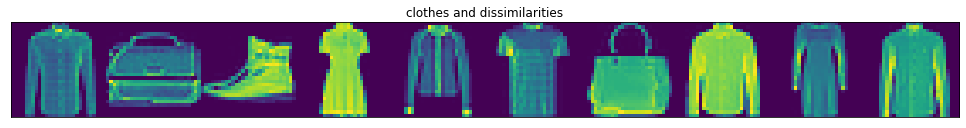

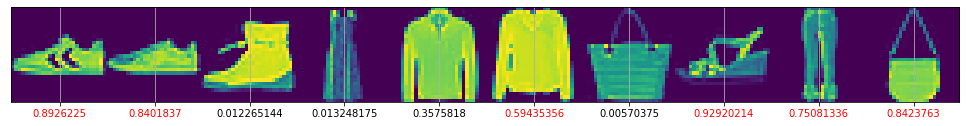

In [54]:
y_pred_train = np.squeeze(y_pred_train)
idx = np.random.choice(len(y_pred_train), size=10)
display_imgs(tr_pairs[:, 0][idx], 
             tr_pairs[:, 1][idx], 
             y_pred_train[idx], 
             tr_y[idx],
             'clothes and dissimilarities',
             10)

(Low numbers mean predicted more similar)